In [1]:
import sys
sys.path.insert(0, '../src')
sys.path.insert(0, '../')

import numpy as np
import torch
import matplotlib.pyplot as plt

from drawing import draw_window, visualize_score_map
from image import get_image_tensor, get_numpy_image
from shape import Window, Position
from roi_align import RoIAlignFeatureExtractor
from image import load_image
from feature_extractor import CNN, ReCNN, ResizeImageFeatureExtractor, FeatureExtractor, EdgeImageFeatureExtractor
from candidates import Candidates
from scorer import CosineSimilarityScorer, Scorer
from shape.basic import Size
from utils.timer import timer

def visualize_result(img: np.ndarray, score_map: np.ndarray, threshold: float, rois: Candidates, best_window: Window, scores: torch.Tensor):
    fig, axes = plt.subplots(1, 4, figsize=(20, 3))
    axes[0].imshow(img)
    axes[1].imshow(score_map)
    axes[2].imshow(score_map > threshold)

    windows = rois.rois.cpu().numpy()
    best_pos_indices = (windows[:, 1] == best_window.cx) & (windows[:, 2] == best_window.cy)
    best_pos_windows = windows[best_pos_indices]
    best_pos_scores = scores.reshape(-1)[best_pos_indices].cpu().numpy()
    angles = best_pos_windows[:, 5]
    axes[3].plot(angles, best_pos_scores)
    axes[3].set_xlabel('angle')
    axes[3].set_ylabel('score')
    axes[3].set_ylim(0.0, 1.0)
    plt.show()

Text(0.5, 1.0, 'target')

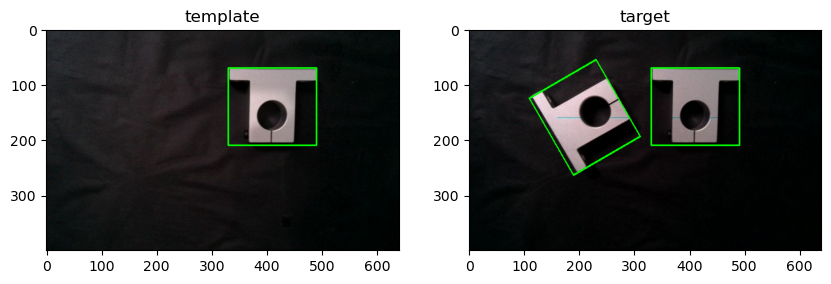

In [2]:
target_img = load_image('../data/image_1.png')
template_img = load_image('../data/template_1.jpg')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

template_window = Window(410., 140., 160., 140., 0)
draw_img = draw_window(template_img, template_window)
axes[0].imshow(draw_img)
axes[0].set_title('template')

target_windows = [
    Window(210, 160, 160, 140, -120),
    Window(410., 140., 160., 140., 0)
    ]
draw_img = target_img.copy()
for target_window in target_windows:
    draw_img = draw_window(draw_img, target_window)
axes[1].imshow(draw_img)
axes[1].set_title('target')

set_template took 0.0393834114074707 seconds to run.
Elapsed time for calc_roi_features   : 4.6991
Elapsed time for calc_scores         : 0.1796
num rois:  576000
num rois after filtered by score:  14
num rois after filtered by iou:  2
find took 5.798202753067017 seconds to run.
DetectedWindow(window=Window(cx=412.0, cy=140.0, width=160.0, height=140.0, angle=0.0), score=0.97686607)
DetectedWindow(window=Window(cx=212.0, cy=160.0, width=160.0, height=140.0, angle=240.0), score=0.9097765)


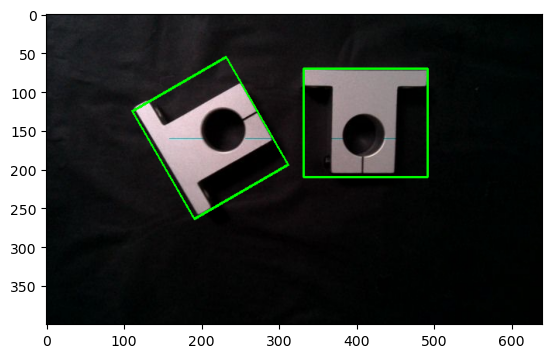

set_template took 0.0031728744506835938 seconds to run.
Elapsed time for calc_roi_features   : 4.6926
Elapsed time for calc_scores         : 0.1711
num rois:  576000
num rois after filtered by score:  3
num rois after filtered by iou:  2
find took 5.479966163635254 seconds to run.
DetectedWindow(window=Window(cx=412.0, cy=140.0, width=160.0, height=140.0, angle=0.0), score=0.9028225)
DetectedWindow(window=Window(cx=216.0, cy=156.0, width=160.0, height=140.0, angle=240.0), score=0.81098396)


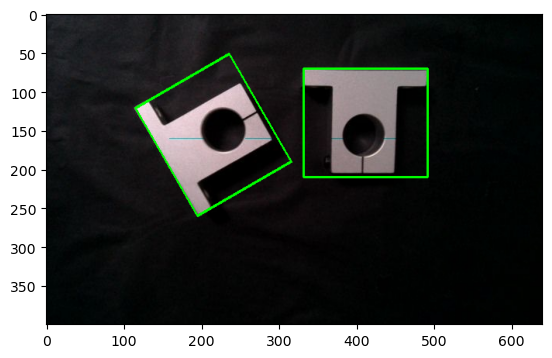

set_template took 0.016463518142700195 seconds to run.
Elapsed time for calc_roi_features   : 4.7355
Elapsed time for calc_scores         : 0.1774
num rois:  576000
num rois after filtered by score:  3
num rois after filtered by iou:  2
find took 5.831421852111816 seconds to run.
DetectedWindow(window=Window(cx=416.0, cy=140.0, width=160.0, height=140.0, angle=0.0), score=0.79059327)
DetectedWindow(window=Window(cx=216.0, cy=160.0, width=160.0, height=140.0, angle=240.0), score=0.75896144)


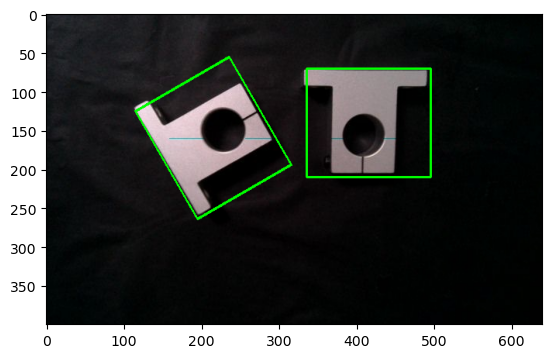

set_template took 0.45533204078674316 seconds to run.
Elapsed time for calc_roi_features   : 4.6997
Elapsed time for calc_scores         : 0.1688
num rois:  576000
num rois after filtered by score:  11
num rois after filtered by iou:  2
find took 6.048400402069092 seconds to run.
DetectedWindow(window=Window(cx=412.0, cy=140.0, width=160.0, height=140.0, angle=0.0), score=0.91812325)
DetectedWindow(window=Window(cx=212.0, cy=156.0, width=160.0, height=140.0, angle=240.0), score=0.8230945)


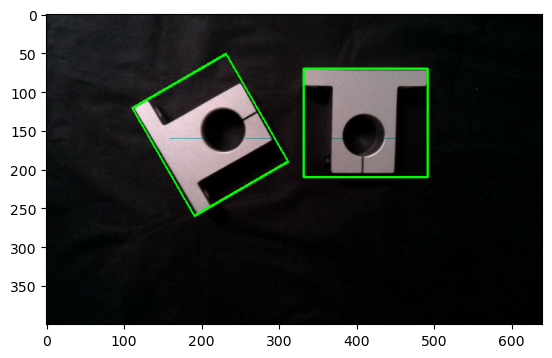

In [3]:
from matcher import NaiveMatcher, SearchParams
from scorer import ZNCCScorer

roi_feature_extractor = RoIAlignFeatureExtractor(output_size=14, sampling_ratio=2)
scorer = ZNCCScorer()

for model_name in ['sobel', 'laplacian', 'canny', 'dexined']:
    feature_extractor = EdgeImageFeatureExtractor(model_name)

    search_params = SearchParams(x_step=4, y_step=4, angle_step=10, score_threshold=0.7, iou_threshold=0.1)
    matcher = NaiveMatcher(feature_extractor, roi_feature_extractor, scorer, scale=2, search_params=search_params)
    matcher.set_template(template_img, template_window)
    detected_windows = matcher.find(target_img)

    draw_img = target_img.copy()
    for window in detected_windows:
        print(window)
        draw_img = draw_window(draw_img, window.window)
    plt.imshow(draw_img)
    plt.show()

set_template took 0.004789590835571289 seconds to run.
Elapsed time for calc_roi_features   : 4.7395
Elapsed time for calc_scores         : 0.1709
num rois:  576000
num rois after filtered by score:  9
num rois after filtered by iou:  2
find took 5.678470134735107 seconds to run.
DetectedWindow(window=Window(cx=412.0, cy=140.0, width=160.0, height=140.0, angle=0.0), score=0.91265893)
DetectedWindow(window=Window(cx=216.0, cy=160.0, width=160.0, height=140.0, angle=240.0), score=0.88968605)


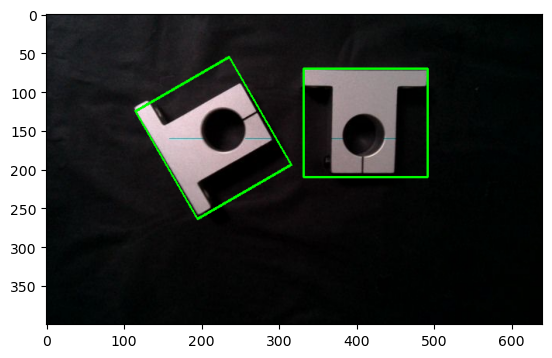

set_template took 0.00244140625 seconds to run.
Elapsed time for calc_roi_features   : 4.7485
Elapsed time for calc_scores         : 0.1696
num rois:  576000
find took 5.671332359313965 seconds to run.


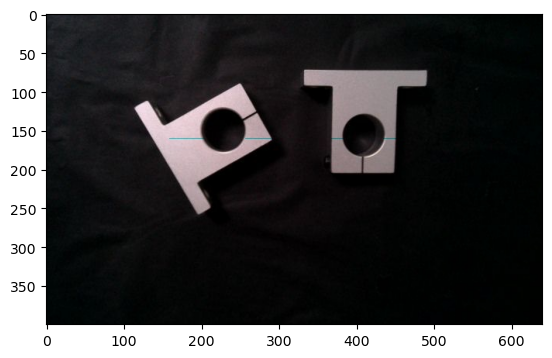

set_template took 0.026731252670288086 seconds to run.
Elapsed time for calc_roi_features   : 4.7300
Elapsed time for calc_scores         : 0.1678
num rois:  576000
num rois after filtered by score:  3
num rois after filtered by iou:  2
find took 5.66895604133606 seconds to run.
DetectedWindow(window=Window(cx=416.0, cy=140.0, width=160.0, height=140.0, angle=0.0), score=0.80002034)
DetectedWindow(window=Window(cx=216.0, cy=160.0, width=160.0, height=140.0, angle=240.0), score=0.74968684)


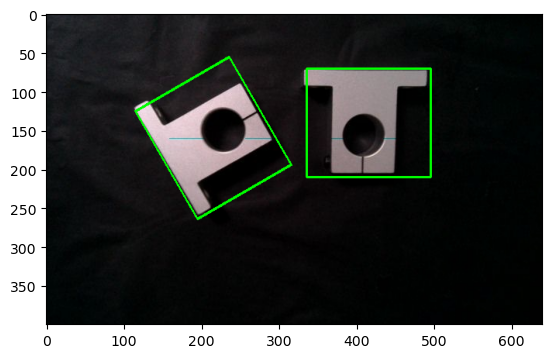

set_template took 0.5018739700317383 seconds to run.
Elapsed time for calc_roi_features   : 4.7211
Elapsed time for calc_scores         : 0.2033
num rois:  576000
num rois after filtered by score:  11
num rois after filtered by iou:  2
find took 6.249706506729126 seconds to run.
DetectedWindow(window=Window(cx=412.0, cy=140.0, width=160.0, height=140.0, angle=0.0), score=0.91812325)
DetectedWindow(window=Window(cx=212.0, cy=156.0, width=160.0, height=140.0, angle=240.0), score=0.8230945)


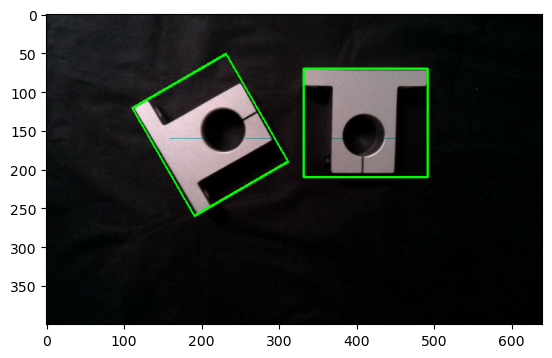

In [5]:
from matcher import NaiveMatcher, SearchParams
from scorer import ZNCCScorer

roi_feature_extractor = RoIAlignFeatureExtractor(output_size=14, sampling_ratio=2)
scorer = ZNCCScorer()

for model_name in ['sobel', 'laplacian', 'canny', 'dexined']:
    feature_extractor = EdgeImageFeatureExtractor(model_name)

    search_params = SearchParams(x_step=4, y_step=4, angle_step=10, score_threshold=0.7, iou_threshold=0.1)
    matcher = NaiveMatcher(feature_extractor, roi_feature_extractor, scorer, scale=2, search_params=search_params)
    matcher.set_template(template_img, template_window)
    detected_windows = matcher.find(target_img)

    draw_img = target_img.copy()
    for window in detected_windows:
        print(window)
        draw_img = draw_window(draw_img, window.window)
    plt.imshow(draw_img)
    plt.show()

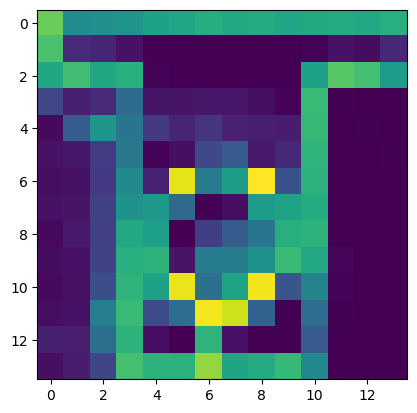

In [4]:
plt.imshow(matcher.template_features[0].reshape(14, 14))